In [1]:
import torch.nn.functional as F
from torch import cuda
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import math
import os
import copy
import timm 
from collections import OrderedDict

from torch.nn.modules.utils import _ntuple


In [2]:
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/storage_labs/3030/BelyakovM/FaceMask_presence/ds'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [3]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Further we are going to test how fast CondenseNet modification infers on our simple task

In [4]:
#Model building blocks
class LearnedGroupConv(nn.Module):
    global_progress = 0.0
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, 
                 condense_factor=None, dropout_rate=0.):
        super(LearnedGroupConv, self).__init__()
        self.norm = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout_rate = dropout_rate
        if self.dropout_rate > 0:
            self.drop = nn.Dropout(dropout_rate, inplace=False)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride,
                              padding, dilation, groups=1, bias=False)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.groups = groups
        self.condense_factor = condense_factor
        if self.condense_factor is None:
            self.condense_factor = self.groups
        ### Parameters that should be carefully used
        self.register_buffer('_count', torch.zeros(1))
        self.register_buffer('_stage', torch.zeros(1))
        self.register_buffer('_mask', torch.ones(self.conv.weight.size()))
        ### Check if arguments are valid
        assert self.in_channels % self.groups == 0, "group number can not be divided by input channels"
        assert self.in_channels % self.condense_factor == 0, "condensation factor can not be divided by input channels"
        assert self.out_channels % self.groups == 0, "group number can not be divided by output channels"

    def forward(self, x):
        self._check_drop()
        x = self.norm(x)
        x = self.relu(x)
        if self.dropout_rate > 0:
            x = self.drop(x)
        ### Masked output
        weight = self.conv.weight * self.mask
        return F.conv2d(x, weight, None, self.conv.stride,
                        self.conv.padding, self.conv.dilation, 1)

    def _check_drop(self):
        progress = LearnedGroupConv.global_progress
        delta = 0
        ### Get current stage
        for i in range(self.condense_factor - 1):
            if progress * 2 < (i + 1) / (self.condense_factor - 1):
                stage = i
                break
        else:
            stage = self.condense_factor - 1
        ### Check for dropping
        if not self._reach_stage(stage):
            self.stage = stage
            delta = self.in_channels // self.condense_factor
        if delta > 0:
            self._dropping(delta)
        return

    def _dropping(self, delta):
        weight = self.conv.weight * self.mask
        ### Sum up all kernels
        ### Assume only apply to 1x1 conv to speed up
        assert weight.size()[-1] == 1
        weight = weight.abs().squeeze()
        assert weight.size()[0] == self.out_channels
        assert weight.size()[1] == self.in_channels
        d_out = self.out_channels // self.groups
        ### Shuffle weight
        weight = weight.view(d_out, self.groups, self.in_channels)
        weight = weight.transpose(0, 1).contiguous()
        weight = weight.view(self.out_channels, self.in_channels)
        ### Sort and drop
        for i in range(self.groups):
            wi = weight[i * d_out:(i + 1) * d_out, :]
            ### Take corresponding delta index
            di = wi.sum(0).sort()[1][self.count:self.count + delta]
            for d in di.data:
                self._mask[i::self.groups, d, :, :].fill_(0)
        self.count = self.count + delta

    @property
    def count(self):
        return int(self._count[0])

    @count.setter
    def count(self, val):
        self._count.fill_(val)

    @property
    def stage(self):
        return int(self._stage[0])
        
    @stage.setter
    def stage(self, val):
        self._stage.fill_(val)

    @property
    def mask(self):
        return Variable(self._mask)

    def _reach_stage(self, stage):
        return (self._stage >= stage).all()

    @property
    def lasso_loss(self):
        if self._reach_stage(self.groups - 1):
            return 0
        weight = self.conv.weight * self.mask
        ### Assume only apply to 1x1 conv to speed up
        assert weight.size()[-1] == 1
        weight = weight.squeeze().pow(2)
        d_out = self.out_channels // self.groups
        ### Shuffle weight
        weight = weight.view(d_out, self.groups, self.in_channels)
        weight = weight.sum(0).clamp(min=1e-6).sqrt()
        return weight.sum()


def ShuffleLayer(x, groups):
    batchsize, num_channels, height, width = x.data.size()
    channels_per_group = num_channels // groups
    ### reshape
    x = x.view(batchsize, groups,
               channels_per_group, height, width)
    ### transpose
    x = torch.transpose(x, 1, 2).contiguous()
    ### flatten
    x = x.view(batchsize, -1, height, width)
    return x


class CondensingLinear(nn.Module):
    def __init__(self, model, drop_rate=0.5):
        super(CondensingLinear, self).__init__()
        self.in_features = int(model.in_features*drop_rate)
        self.out_features = model.out_features
        self.linear = nn.Linear(self.in_features, self.out_features)
        self.register_buffer('index', torch.LongTensor(self.in_features))
        _, index = model.weight.data.abs().sum(0).sort()
        index = index[model.in_features-self.in_features:]
        self.linear.bias.data = model.bias.data.clone()
        for i in range(self.in_features):
            self.index[i] = index[i]
            self.linear.weight.data[:, i] = model.weight.data[:, index[i]]

    def forward(self, x):
        x = torch.index_select(x, 1, Variable(self.index))
        x = self.linear(x)
        return x


class CondensingConv(nn.Module):
    def __init__(self, model):
        super(CondensingConv, self).__init__()
        self.in_channels = model.conv.in_channels \
                         * model.groups // model.condense_factor
        self.out_channels = model.conv.out_channels
        self.groups = model.groups
        self.condense_factor = model.condense_factor
        self.norm = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(self.in_channels, self.out_channels,
                              kernel_size=model.conv.kernel_size,
                              padding=model.conv.padding,
                              groups=self.groups,
                              bias=False,
                              stride=model.conv.stride)
        self.register_buffer('index', torch.LongTensor(self.in_channels))
        index = 0
        mask = model._mask.mean(-1).mean(-1)
        for i in range(self.groups):
            for j in range(model.conv.in_channels):
                if index < (self.in_channels // self.groups) * (i + 1) \
                         and mask[i, j] == 1:
                    for k in range(self.out_channels // self.groups):
                        idx_i = int(k + i * (self.out_channels // self.groups))
                        idx_j = index % (self.in_channels // self.groups)
                        self.conv.weight.data[idx_i, idx_j, :, :] = \
                            model.conv.weight.data[int(i + k * self.groups), j, :, :]
                        self.norm.weight.data[index] = model.norm.weight.data[j]
                        self.norm.bias.data[index] = model.norm.bias.data[j]
                        self.norm.running_mean[index] = model.norm.running_mean[j]
                        self.norm.running_var[index] = model.norm.running_var[j]
                    self.index[index] = j
                    index += 1

    def forward(self, x):
        x = torch.index_select(x, 1, Variable(self.index))
        x = self.norm(x)
        x = self.relu(x)
        x = self.conv(x)
        x = ShuffleLayer(x, self.groups)
        return x


class CondenseLinear(nn.Module):
    def __init__(self, in_features, out_features, drop_rate=0.5):
        super(CondenseLinear, self).__init__()
        self.in_features = int(in_features*drop_rate)
        self.out_features = out_features
        self.linear = nn.Linear(self.in_features, self.out_features)
        self.register_buffer('index', torch.LongTensor(self.in_features))

    def forward(self, x):
        x = torch.index_select(x, 1, Variable(self.index))
        x = self.linear(x)
        return x


class CondenseConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, 
                 stride=1, padding=0, groups=1):
        super(CondenseConv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.groups = groups
        self.norm = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(self.in_channels, self.out_channels,
                              kernel_size=kernel_size,
                              stride=stride,
                              padding=padding,
                              groups=self.groups,
                              bias=False)
        self.register_buffer('index', torch.LongTensor(self.in_channels))
        self.index.fill_(0)

    def forward(self, x):
        x = torch.index_select(x, 1, Variable(self.index))
        x = self.norm(x)
        x = self.relu(x)
        x = self.conv(x)
        x = ShuffleLayer(x, self.groups)
        return x


class Conv(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size, 
                 stride=1, padding=0, groups=1):
        super(Conv, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(in_channels))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(in_channels, out_channels,
                                          kernel_size=kernel_size,
                                          stride=stride,
                                          padding=padding, bias=False,
                                          groups=groups))

In [5]:
#Arguements initialization
import argparse
parser = argparse.ArgumentParser(description='PyTorch Condensed Convolutional Networks')

parser.add_argument('--data', metavar='DIR',help='path to dataset')

parser.add_argument('--model', default='condensenet', type=str, metavar='M',
                    help='model to train the dataset')
parser.add_argument('-j', '--workers', default=8, type=int, metavar='N',
                    help='number of data loading workers (default: 4)')
parser.add_argument('--epochs', default=120, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('--start-epoch', default=0, type=int, metavar='N',
                    help='manual epoch number (useful on restarts)')
parser.add_argument('-b', '--batch-size', default=256, type=int,
                    metavar='N', help='mini-batch size (default: 256)')
parser.add_argument('--lr', '--learning-rate', default=0.1, type=float,
                    metavar='LR', help='initial learning rate (default: 0.1)')
parser.add_argument('--lr-type', default='cosine', type=str, metavar='T',
                    help='learning rate strategy (default: cosine)',
                    choices=['cosine', 'multistep'])
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum (default: 0.9)')
parser.add_argument('--weight-decay', '--wd', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)')
parser.add_argument('--print-freq', '-p', default=10, type=int,
                    metavar='N', help='print frequency (default: 10)')
parser.add_argument('--pretrained', dest='pretrained', action='store_true',
                    help='use pre-trained model (default: false)')
parser.add_argument('--no-save-model', dest='no_save_model', action='store_true',
                    help='only save best model (default: false)')
parser.add_argument('--manual-seed', default=0, type=int, metavar='N',
                    help='manual seed (default: 0)')
parser.add_argument('--gpu', default='cuda:0',
                    help='cuda:0')

parser.add_argument('--savedir', type=str, metavar='PATH', default='results/savedir',
                    help='path to save result and checkpoint (default: results/savedir)')
parser.add_argument('--resume', action='store_true',
                    help='use latest checkpoint if have any (default: none)')

parser.add_argument('--stages', type=str, metavar='STAGE DEPTH',
                    help='per layer depth')
parser.add_argument('--bottleneck', default=4, type=int, metavar='B',
                    help='bottleneck (default: 4)')
parser.add_argument('--group-1x1', type=int, metavar='G', default=4,
                    help='1x1 group convolution (default: 4)')
parser.add_argument('--group-3x3', type=int, metavar='G', default=4,
                    help='3x3 group convolution (default: 4)')
parser.add_argument('--condense-factor', type=int, metavar='C', default=4,
                    help='condense factor (default: 4)')
parser.add_argument('--growth', type=str, metavar='GROWTH RATE',
                    help='per layer growth')
parser.add_argument('--reduction', default=0.5, type=float, metavar='R',
                    help='transition reduction (default: 0.5)')
parser.add_argument('--dropout-rate', default=0, type=float,
                    help='drop out (default: 0)')
parser.add_argument('--group-lasso-lambda', default=0., type=float, metavar='LASSO',
                    help='group lasso loss weight (default: 0)')

parser.add_argument('--evaluate', action='store_true',
                    help='evaluate model on validation set (default: false)')
parser.add_argument('--convert-from', default=None, type=str, metavar='PATH',
                    help='path to saved checkpoint (default: none)')
parser.add_argument('--evaluate-from', default=None, type=str, metavar='PATH',
                    help='path to saved checkpoint (default: none)')
args = parser.parse_args([])



In [6]:
args.stages = '4-6-8-10-8'
args.growth = '8-16-32-64-128'
os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu
args.stages = list(map(int, args.stages.split('-')))
args.growth = list(map(int, args.growth.split('-')))
args.num_classes = 2

In [8]:
#Model building blocks
__all__ = ['CondenseNet']


class _DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate, args):
        super(_DenseLayer, self).__init__()
        self.group_1x1 = args.group_1x1
        self.group_3x3 = args.group_3x3
        ### 1x1 conv i --> b*k
        self.conv_1 = LearnedGroupConv(in_channels, args.bottleneck * growth_rate,
                                       kernel_size=1, groups=self.group_1x1,
                                       condense_factor=args.condense_factor,
                                       dropout_rate=args.dropout_rate)
        ### 3x3 conv b*k --> k
        self.conv_2 = Conv(args.bottleneck * growth_rate, growth_rate,
                           kernel_size=3, padding=1, groups=self.group_3x3)

    def forward(self, x):
        x_ = x
        x = self.conv_1(x)
        x = self.conv_2(x)
        return torch.cat([x_, x], 1)


class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, in_channels, growth_rate, args):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(in_channels + i * growth_rate, growth_rate, args)
            self.add_module('denselayer_%d' % (i + 1), layer)


class _Transition(nn.Module):
    def __init__(self, in_channels, args):
        super(_Transition, self).__init__()
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(x)
        return x


class CondenseNet(nn.Module):
    def __init__(self, args):

        super(CondenseNet, self).__init__()

        self.stages = args.stages
        self.growth = args.growth
        assert len(self.stages) == len(self.growth)
        self.args = args
        self.progress = 0.0
        if args.data in ['cifar10', 'cifar100']:
            self.init_stride = 1
            self.pool_size = 8
        else:
            self.init_stride = 2
            self.pool_size = 7

        self.features = nn.Sequential()
        ### Initial nChannels should be 3
        self.num_features = 2 * self.growth[0]
        ### Dense-block 1 (224x224)
        self.features.add_module('init_conv', nn.Conv2d(3, self.num_features,
                                                        kernel_size=3,
                                                        stride=self.init_stride,
                                                        padding=1,
                                                        bias=False))
        for i in range(len(self.stages)):
            ### Dense-block i
            self.add_block(i)
        ### Linear layer
        self.classifier = nn.Linear(self.num_features, args.num_classes)

        ### initialize
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
        return

    def add_block(self, i):
        ### Check if ith is the last one
        last = (i == len(self.stages) - 1)
        block = _DenseBlock(
            num_layers=self.stages[i],
            in_channels=self.num_features,
            growth_rate=self.growth[i],
            args=self.args,
        )
        self.features.add_module('denseblock_%d' % (i + 1), block)
        self.num_features += self.stages[i] * self.growth[i]
        if not last:
            trans = _Transition(in_channels=self.num_features,
                                args=self.args)
            self.features.add_module('transition_%d' % (i + 1), trans)
        else:
            self.features.add_module('norm_last',
                                     nn.BatchNorm2d(self.num_features))
            self.features.add_module('relu_last',
                                     nn.ReLU(inplace=True))
            self.features.add_module('pool_last',
                                     nn.AvgPool2d(self.pool_size))

    def forward(self, x, progress=None):
        if progress:
            LearnedGroupConv.global_progress = progress
        features = self.features(x)
        out = features.view(features.size(0), -1)
        out = self.classifier(out)
        return out

## The model's pretrained weights aren't available, but data isn't scarce. So it follows that quite a number of epochs are reqiured to fine-tune the model

In [9]:
# Model initialization
model_ft = CondenseNet(args)


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=9)

Epoch 0/8
----------
train Loss: 0.3927 Acc: 0.8179
val Loss: 0.3717 Acc: 0.8448

Epoch 1/8
----------
train Loss: 0.3057 Acc: 0.8675
val Loss: 0.2672 Acc: 0.9063

Epoch 2/8
----------
train Loss: 0.2483 Acc: 0.8933
val Loss: 0.1856 Acc: 0.9370

Epoch 3/8
----------
train Loss: 0.2185 Acc: 0.9070
val Loss: 0.1678 Acc: 0.9437

Epoch 4/8
----------
train Loss: 0.1987 Acc: 0.9152
val Loss: 0.1724 Acc: 0.9394

Epoch 5/8
----------
train Loss: 0.1865 Acc: 0.9214
val Loss: 0.1180 Acc: 0.9604

Epoch 6/8
----------
train Loss: 0.1698 Acc: 0.9280
val Loss: 0.1223 Acc: 0.9542

Epoch 7/8
----------
train Loss: 0.1561 Acc: 0.9334
val Loss: 0.1052 Acc: 0.9632

Epoch 8/8
----------
train Loss: 0.1540 Acc: 0.9353
val Loss: 0.1065 Acc: 0.9620

Training complete in 47m 30s
Best val Acc: 0.963232


## Let's visualize a few model val predictions

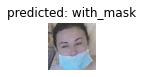

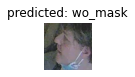

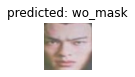

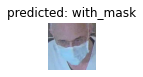

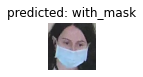

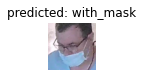

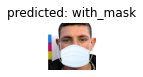

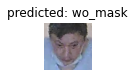

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



num_images = 8
was_training = model_ft.training
model_ft.eval()
images_counter = 0
fig = plt.figure()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        for j in range(inputs.size()[0]):
            images_counter += 1
            ax = plt.subplot(num_images//2, 2, images_counter)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_counter == num_images:
                model_ft.train(mode=was_training)
                break
        model_ft.train(mode=was_training)
        if images_counter == num_images:
            break

### Let's find out how fast the model is going to work during inference on gpu

In [32]:
from utils import get_time_my
get_time_my('CondenseNet',model_ft,224,224,device)

CondenseNet 20.61715446090698  224_224


20.61715446090698

In [33]:
dummy = torch.randn(1, 3, 224, 224, device='cuda')
input_names = [ "actual_input_1" ] 
output_names = [ "output1" ]
#model_ft.set_swish(memory_efficient=False)
torch.onnx.export(model_ft, dummy, "FaceMask_CondenseNet_224.onnx", verbose=False, input_names=input_names, output_names=output_names,export_params=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:51: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!


In [1]:
!nvidia-smi


Tue Aug 24 08:13:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 440.44       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:04:00.0 Off |                  N/A |
| 31%   20C    P8     1W / 250W |  10978MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:05:00.0 Off |                  N/A |
| 29%   21C    P8     5W / 250W |   1264MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        